# Pyem comparison

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
from  matplotlib import pyplot as plt
plt.rcParams["figure.figsize"]=10,10

from src.utils import volume_fourier, mip_x, mip_z, create_mask
from src.projection import project
#from src.interpolate import *

In [3]:
from external.pyem.project import project as project_pyem
from external.pyem.pyem import star
from external.pyem.pyem import vop
from pyfftw.builders import irfft2

### The volume

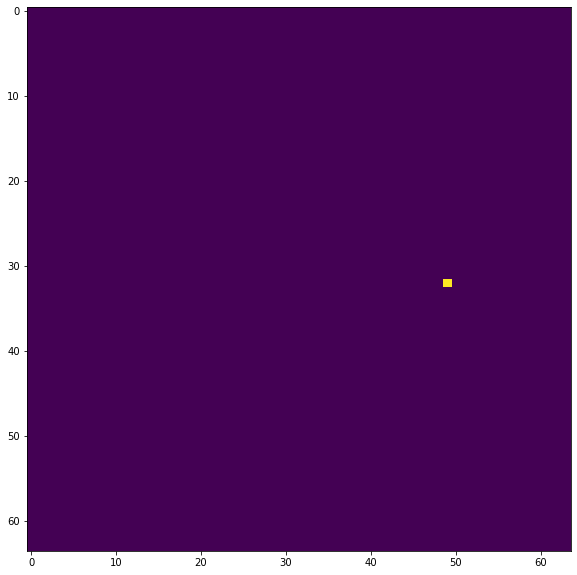

In [4]:
nx = 64
dx = 0.2

vol = np.zeros([nx,nx,nx])
vol[32,49,32] = 1

vol_pyem = np.zeros([nx,nx,nx])
vol_pyem[32,32,49] = 1

mip_x(vol_pyem)

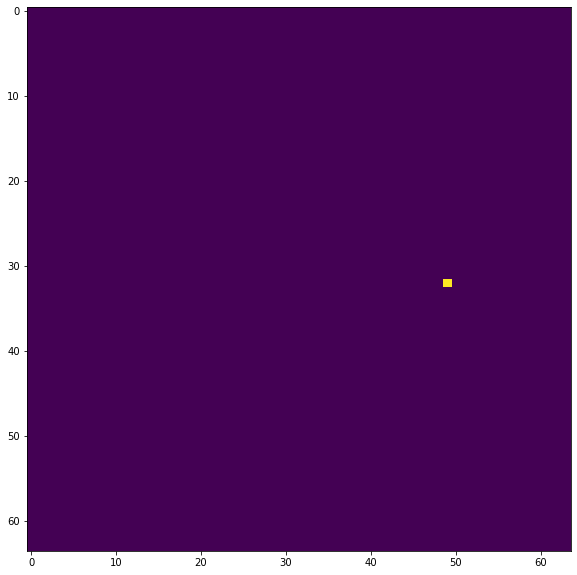

In [5]:
mip_z(vol)

In [6]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

pfac = 2
f3d_pyem = vop.vol_ft(vol_pyem, pfac=pfac, threads=1)
#plt.imshow(np.real(f3d_pyem[:,:,3])); plt.colorbar()

rrmax =  64


In [7]:
f3d_pyem.shape

(131, 131, 65)

### Pyem projection

Parameters from the star file:

https://relion.readthedocs.io/en/release-3.1/Reference/Conventions.html?highlight=star#star-format

In [152]:
df = star.parse_star("../external/pyem/pyem.star", keep_index = False)
dfiter = df.iterrows()
i, p = next(dfiter)
#i, p = next(dfiter)

#p["rlnVoltage"] = 0
#p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = 0
p[star.Relion.ORIGINY] = 0

# These don't seem to make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
p[star.Relion.ORIGINXANGST] = 0
p[star.Relion.ORIGINYANGST] = 0

p[star.Relion.ANGLEROT] = 45 # Around the z axis (first axis)
p[star.Relion.ANGLETILT] = 0 # Around the new y axis 
p[star.Relion.ANGLEPSI] = 0 # Arond the new z axis


p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

p[star.Relion.DEFOCUSU] = 0
p[star.Relion.DEFOCUSV] = 0
p[star.Relion.DEFOCUSANGLE] = 0

pzero = p.copy()

/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/Users/bogdan/Work/3_PostdocYale/simple_cryoem/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


Bogdan2
rmax = 32
(64, 33)


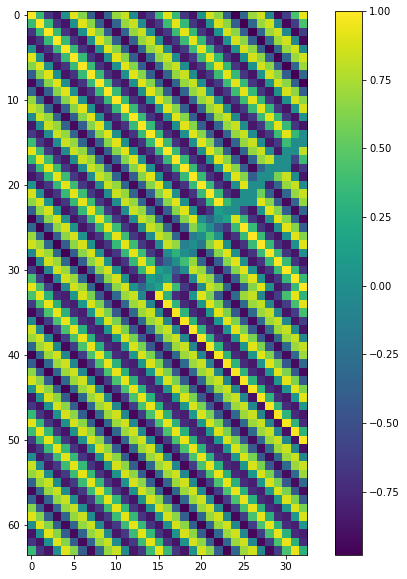

In [153]:
#pfac = 2

size = (f3d_pyem.shape[0] - 3) // pfac
sz = (f3d_pyem.shape[0] - 3) // pfac
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx ** 2 + sy ** 2)
a = np.arctan2(sy, sx)

f2d_pyem = project_pyem(f3d_pyem, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False)


ift = irfft2(f2d_pyem.copy(), threads=1, planner_effort="FFTW_ESTIMATE", auto_align_input=True, auto_contiguous=True)
proj_pyem = np.fft.fftshift(ift(f2d_pyem.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype)))

plt.imshow(np.real(f2d_pyem)); plt.colorbar()
print(f2d_pyem.shape)

### My projection

In [154]:
dimensions = np.array([1,1,1])

f3d, X, Y, Z, _, _, _ = volume_fourier(np.fft.ifftshift(vol), dimensions)

#mymask = create_mask(X,Y,Z, (0,0,0), np.max(X))
#f3d = f3d * mymask

x_freq = X[0,:,0]
y_freq = Y[:,0,0]
z_freq = Z[0,0,:]

# IMPORTANT: do not make this a Jax array
x_grid = np.array([x_freq[1], len(x_freq)])
y_grid = np.array([y_freq[1], len(y_freq)])
z_grid = np.array([z_freq[1], len(z_freq)])

angles = [0,0,np.pi/4]

In [155]:
#mymask.shape
#mip_z(np.fft.fftshift(mymask))

In [156]:
f2d, coords_slice = project(f3d, x_grid, y_grid, z_grid, angles, 'tri')
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
#f2d = np.fft.fftshift(f2d)

In [157]:
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d)))

In [158]:
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d)))))

0.5305240476093791

### Compare

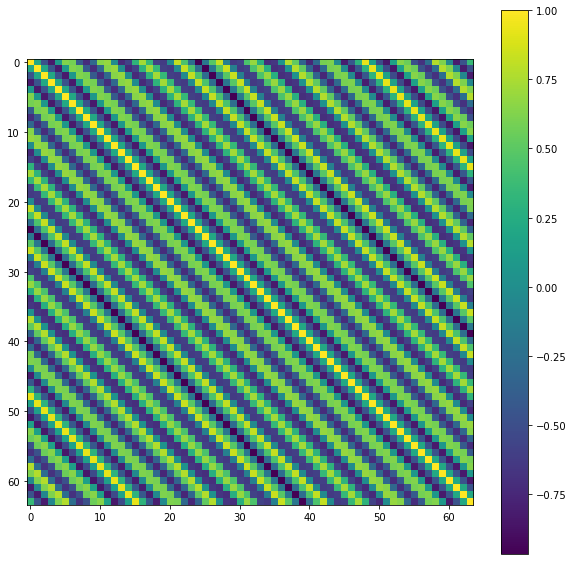

In [159]:
plt.imshow(np.fft.fftshift(np.real(f2d))); plt.colorbar()

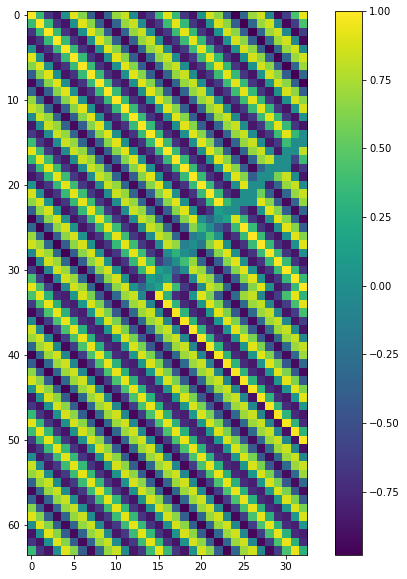

In [160]:
plt.imshow(np.real(f2d_pyem)); plt.colorbar()

### Compute the full FFT of the pyem object so I can fftshift it and see if it makes sense.

In [161]:
f2d_pyem_full = np.zeros(f2d.shape, dtype = f2d_pyem.dtype)
f2d_pyem_full[:,0:33] = f2d_pyem

for k1 in range(64):
    for k2 in range(32,64):
        if k1 == 0:
            kk1 = 0
        else: 
            kk1 = 64-k1
            
        if k2 == 0:
            kk2 = 0
        else:
            kk2 = 64-k2
            
        f2d_pyem_full[k1,k2] = np.conj(f2d_pyem[kk1, kk2])

2.4553081550732108

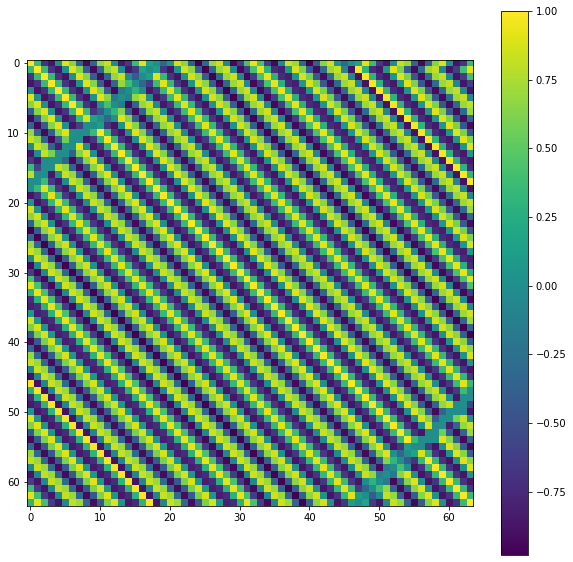

In [162]:
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full))); plt.colorbar()
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d_pyem_full)))))

In [163]:
fs = np.fft.fftshift(f2d)
fs[0,0]

(1+0j)

1.8114407598377713


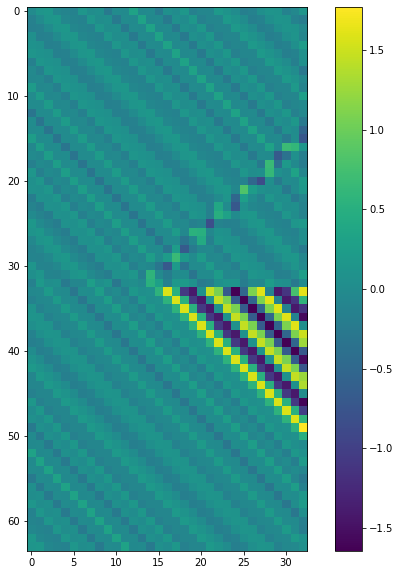

In [164]:
diff = np.array(f2d[:,0:33]-f2d_pyem)

plt.imshow(np.imag(diff)); plt.colorbar()
print(np.max(np.abs(diff)))


1.8114407598377713


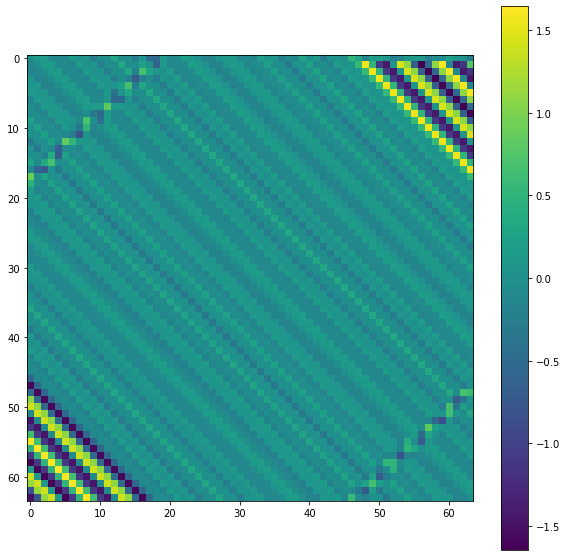

In [165]:
diff_full = np.array(f2d - f2d_pyem_full)

plt.imshow(np.imag(np.fft.fftshift(diff_full))); plt.colorbar()
print(np.max(np.abs(diff_full)))

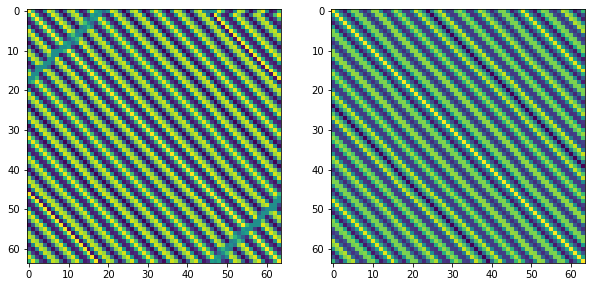

In [166]:
plt.subplot(1,2,1)
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full)));
plt.subplot(1,2,2)
plt.imshow(np.fft.fftshift(np.real(f2d)));

In [167]:
diff_full_shifted = np.fft.fftshift(diff_full)
f2d_shifted = np.fft.fftshift(f2d)
f2d_pyem_full_shifted = np.fft.fftshift(f2d_pyem_full)

d = np.zeros(64, dtype = np.complex128)
f = np.zeros(64, dtype = np.complex128)
fpyem = np.zeros(64, dtype = np.complex128)
for i in range(64):
    d[i] = diff_full_shifted[63-i,i]    
    f[i] = f2d_shifted[63-i,i]
    fpyem[i] = f2d_pyem_full_shifted[63-i,i]

In [151]:
f2d0 = np.fft.fftshift(f2d)
f0 = f2d[0,:]

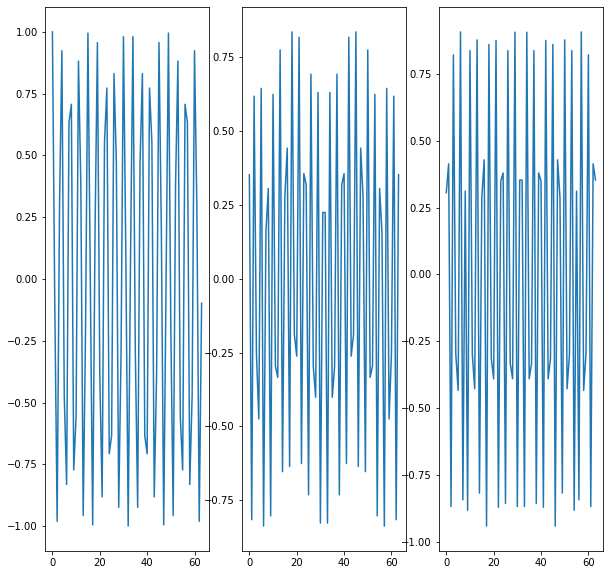

In [171]:
plt.subplot(1,3,1)
plt.plot(np.real(f0))
plt.subplot(1,3,2)
plt.plot(np.real(f))
plt.subplot(1,3,3)
plt.plot(np.real(fpyem))

0.5967786835234412


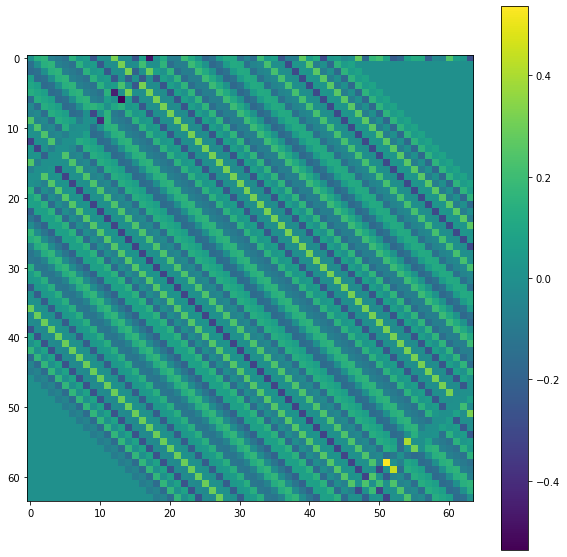

In [109]:
diff_full[np.abs(diff_full) > 0.6] = 0
plt.imshow(np.imag(np.fft.fftshift(diff_full))); plt.colorbar()


print(np.max(np.abs(diff_full)))


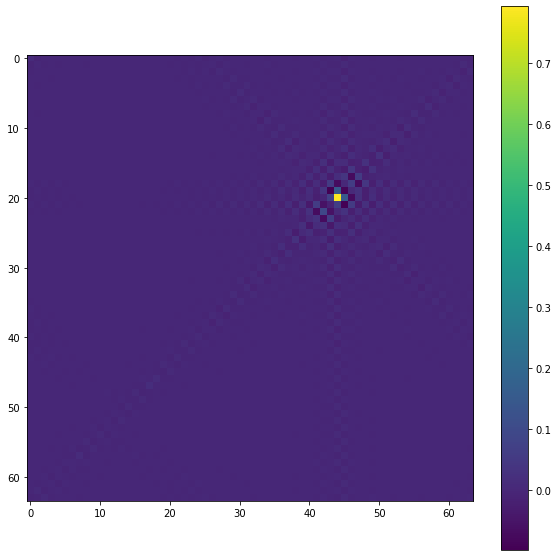

In [85]:
plt.imshow(proj_pyem); plt.colorbar()

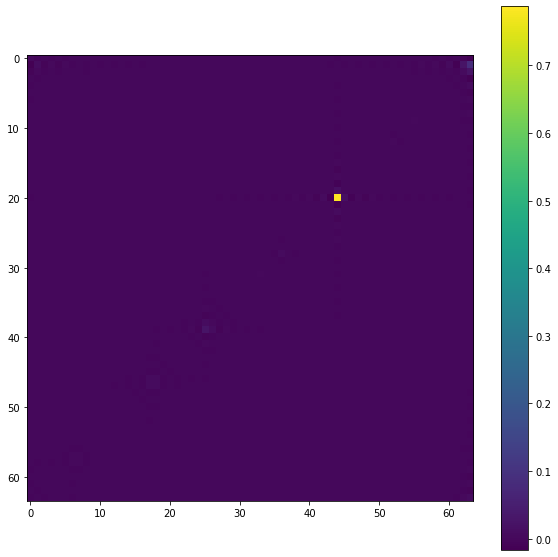

In [86]:
plt.imshow(proj); plt.colorbar()

In [87]:
proj_pyem_full = np.fft.fftshift(np.fft.ifftn(f2d_pyem_full))

np.sum(np.abs(np.imag(proj_pyem_full)))

2.4553081550732108

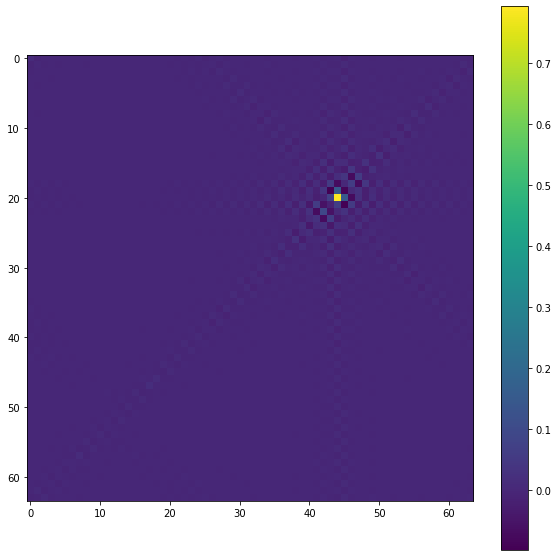

In [88]:
plt.imshow(np.real(proj_pyem_full)); plt.colorbar()

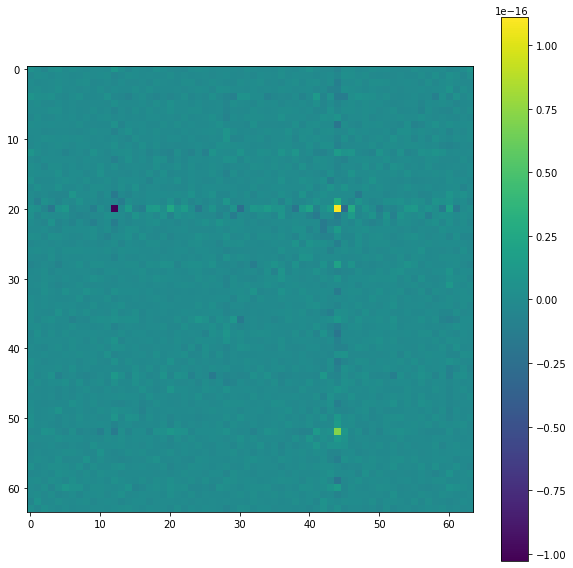

In [89]:
plt.imshow(np.real(proj_pyem-proj_pyem_full)); plt.colorbar()